# k-means clustering to reduce spatial data set size

This notebook reduces the size of a spatial data set by clustering with k-means. More info: http://geoffboeing.com/2014/08/visualizing-summer-travels/

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook webpage
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, kmeans2, whiten

In [2]:
# load the data set
df = pd.read_csv('data/summer-travel-gps-full.csv')
df.head()

,lat,lon,date,city,country
0,51.481292,-0.451011,05/14/2014 09:07,West Drayton,United Kingdom
1,51.474005,-0.450999,05/14/2014 09:22,Hounslow,United Kingdom
2,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom
3,51.478199,-0.446081,05/14/2014 11:24,Hounslow,United Kingdom
4,51.474146,-0.451562,05/14/2014 11:38,Hounslow,United Kingdom


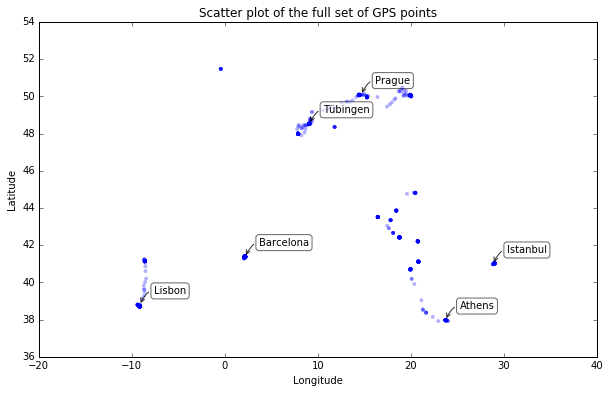

In [3]:
# convert the lat-long coordinates into a two-dimensional numpy array and plot it
coordinates = df.as_matrix(columns=['lon', 'lat'])

most_index = df['city'].value_counts().head(6).index
most = pd.DataFrame(df[df['city'].isin(most_index)])
most.drop_duplicates(subset=['city'], keep='first', inplace=True)

plt.figure(figsize=(10, 6), dpi=100)
co_scatter = plt.scatter(coordinates[:,0], coordinates[:,1], c='b', edgecolor='', s=15, alpha=0.3)

plt.title('Scatter plot of the full set of GPS points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

for i, row in most.iterrows():
    plt.annotate(row['city'], 
                 xy=(row['lon'], row['lat']),
                 xytext=(row['lon'] + 1.5, row['lat'] + 0.6),
                 bbox=dict(boxstyle='round', color='k', fc='w', alpha=0.6),
                 xycoords='data',
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='k', alpha=0.8))

plt.show()

In [4]:
# N is the number of observations to group into k clusters
N = len(coordinates)

# normalize the coordinate data with the whiten function
# each feature is divided by its standard deviation across all observations to give it unit variance.
w = whiten(coordinates)

# k is the number of clusters to form
k = 100

# i is the number of iterations to perform
i = 50

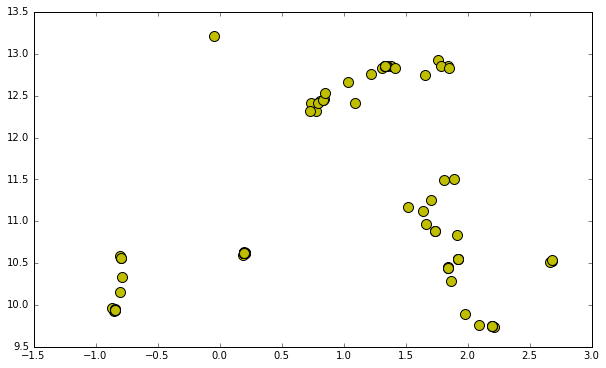

In [5]:
# performs k-means on a set of observation vectors forming k clusters
# returns a k-length array of cluster centroid coordinates, and the final distortion
cluster_centroids1, distortion = kmeans(w, k, iter=i)

# plot the cluster centroids
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(cluster_centroids1[:,0], cluster_centroids1[:,1], c='y', s=100)
plt.show()

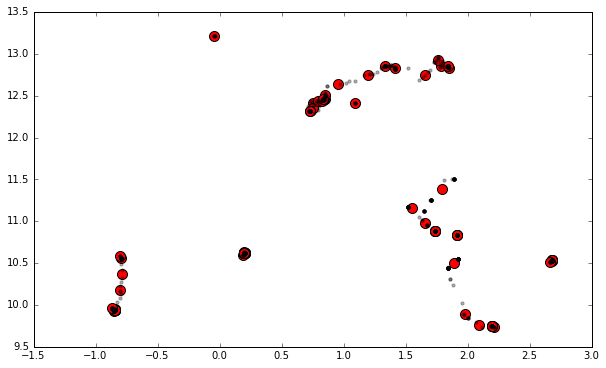

In [6]:
# the kmeans2 function classifies the set of observations into k clusters using the k-means algorithm
# returns a k by N array of centroids found at the last iteration of k-means,
# and an index of the centroid the i'th observation is closest to
# use optional argument minit='points' because the data is not evenly distributed
# minit='points' will choose k observations (rows) at random from data for the initial centroids
cluster_centroids2, closest_centroids = kmeans2(w, k, iter=i, minit='points')

# plot the cluster centroids
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(cluster_centroids2[:,0], cluster_centroids2[:,1], c='r', s=100)
plt.scatter(w[:,0], w[:,1], c='k', alpha=.3, s=10)
plt.show()

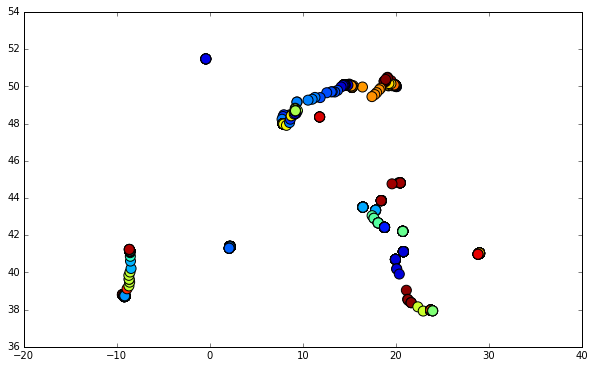

In [7]:
# plot the original full data set colored by cluster - not very useful with this many clusters
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(coordinates[:,0], coordinates[:,1], c=closest_centroids, s=100)
plt.show()

In [8]:
print('k =', k)
print('N =', N)

# the size of cluster_centroids1 and cluster_centroids2 should be the same as k
print(len(cluster_centroids1)) # appears some clusters collapsed, giving us a value less than k
print(len(cluster_centroids2))

# the size of closest_centroids should be the same as N
print(len(closest_centroids))

# the number of unique elements in closest_centroids should be the same as k
print(len(np.unique(closest_centroids)))

k = 100
N = 1759
97
100
1759
100


In [9]:
# for each set of coordinates in our full data set, add the closest_centroid from the kmeans2 clustering
rs = pd.DataFrame(df)
rs['closest_centroid'] = closest_centroids

# reduce the data set so there is only one row for each closest_centroid
rs.drop_duplicates(subset=['closest_centroid'], keep='first', inplace=True)
rs.head()

,lat,lon,date,city,country,closest_centroid
0,51.481292,-0.451011,05/14/2014 09:07,West Drayton,United Kingdom,9
7,38.781775,-9.137544,05/14/2014 15:11,Lisbon,Portugal,31
11,38.742987,-9.147780,05/14/2014 16:11,Lisbon,Portugal,27
12,38.712816,-9.139833,05/14/2014 16:25,Lisbon,Portugal,84
13,38.711050,-9.139739,05/14/2014 16:40,Lisbon,Portugal,52


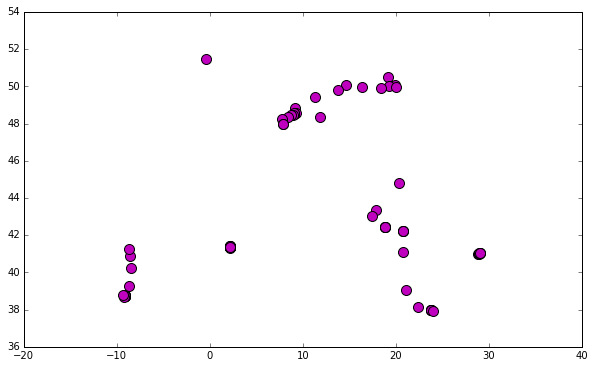

In [10]:
# plot the final reduced set of coordinate points
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(rs['lon'], rs['lat'], c='m', s=100)
plt.show()

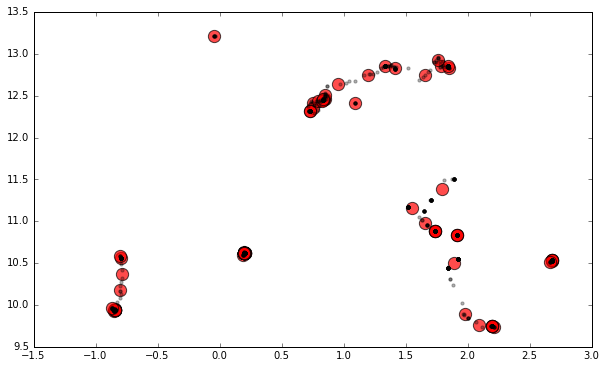

In [11]:
# plot the cluster centroids vs the whitened coordinate points
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(cluster_centroids2[:,0], cluster_centroids2[:,1], c='r', alpha=.7, s=150)
plt.scatter(w[:,0], w[:,1], c='k', alpha=.3, s=10)
plt.show()

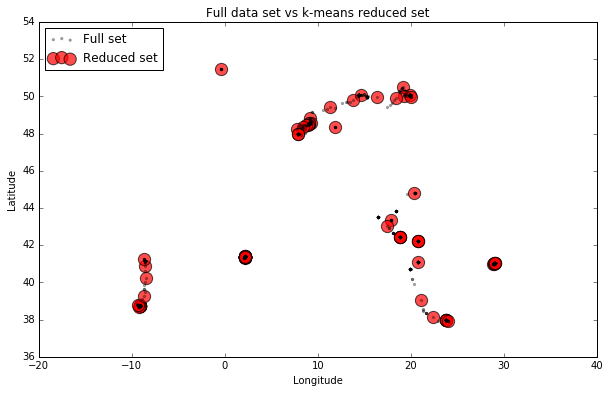

In [12]:
# plot the final reduced set of coordinate points vs the original full set
plt.figure(figsize=(10, 6), dpi=100)
rs_scatter = plt.scatter(rs['lon'], rs['lat'], c='r', alpha=.7, s=150)
df_scatter = plt.scatter(df['lon'], df['lat'], c='k', alpha=.3, s=5)

plt.title('Full data set vs k-means reduced set')
plt.legend((df_scatter, rs_scatter), ('Full set', 'Reduced set'), loc='upper left')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [13]:
#rs.to_csv('data/summer-travel-gps-kmeans.csv', index=False)